To fit the exported UV melting files, QC, append data to a standard format table, and make analysis plots.

This notebook contains dirty code to use for developing `uv.py`.

In [1]:
%load_ext autoreload
%autoreload 2
%run nnn/ipynb_init.py
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import os, json
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import warnings
warnings.filterwarnings("ignore")
from nnn.uv import *

In [2]:
# datadir = '/mnt/d/data/nnn/ECLExport'
datadir = "/Users/yuxi/Library/CloudStorage/GoogleDrive-kyx@stanford.edu/Shared drives/NNN_project/data/UVmelting/ECLExport/221106_TRIloop7_hairpin_25mM-Na"
data_list = [fn for fn in absolute_file_paths(datadir) if fn.endswith('.csv')]

In [13]:
# summary_table = pd.read_table('/mnt/d/data/nnn/SummaryUVMeltingExperiments.tsv')
# summary_table = summary_table.query('Usable').drop(columns=['ProtocolID','Usable','PrepareFresh'])
# summary_table['DateCompleted'] = summary_table['DateCompleted'].apply(lambda x: ''.join(x.split('-'))[2:])

,DateCompleted,Description,Oligo,OligoConcentrationuM,NaConcmM,SnapFreeze,Blank,NumberOfCycles,MinTemperature,MaxTemperature,Result
0,220526,SL001_1M-Na_test,SL001,"4,2,1,0.5",1000,False,False,2,5,95,First 2 are good
2,220712,WC2378_hairpin_1M-Na_conc_test,WC2378,"128,64,32,16,8,4,2",1000,False,False,2,5,95,Those <=16uM are good
3,220727,WC68_hairpin_1M-Na_conc_test,WC68,"1,2,4,5,8,10,12",1000,False,False,2,5,95,Good
4,220809,WC_batch1_hairpin_1M-Na,"WC1106,WC1048,WC1394,WC200,WC578,WC1025,WC1154",6.4,1000,False,False,2,5,95,Great!
5,220828,WC_batch1_hairpin_50mM-Na,"WC1048,WC1394,WC200,WC578,WC1025,WC1154,WC788",6.4,50,True,True,2,12,85,Some curves look funny but mostly fine
8,220904,WC_batch1_hairpin_25mM-Na,"WC1048,WC1394,WC200,WC578,WC1025,WC1154,WC788",3.2,25,True,True,2,12,85,OK to use
9,220908,WC_batch2_hairpin_25mM-Na,"WC788,WC1432,WC1203,WC2922,WC91,WC2119,WC2215",3.2,25,True,True,3,12,85,Only some of the first melt curves were usable...
13,221013,WC1025_duplex_25mM-Na_higher_conc,"WC1025_stem,WC1025_stem,WC1025_stem,WC1025_spl...","48,72,96,48,72,96",25,False,False,2,1,45,Only the 72uM stem one works perfectly. The 48...


In [47]:
summary_table = pd.read_csv('/mnt/d/data/nnn/SummaryUVMeltingExperimentsModified.csv', index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/d/data/nnn/SummaryUVMeltingExperimentsModified.csv'

In [ ]:
"""
Transfer into long form sample sheet
"""

sample_columns = ['curve_date', 'curve_num', 'SEQID', 'conc_uM', 'Na_mM', 'celsius_min', 'celsius_max']
sample_df = pd.DataFrame(columns=sample_columns)

for i,row in summary_table.iterrows():

    oligo_list = row['Oligo'].split(',')
    conc_list = row['OligoConcentrationuM'].split(',')
    n = max(len(oligo_list), len(conc_list))
    if len(oligo_list) == 1:
        oligo_list = [oligo_list[0] for _ in range(n)]
    if len(conc_list) == 1:
        conc_list = [conc_list[0] for _ in range(n)]
    
    if n > 1:
        for i in range(n):
            sample_dict = dict(curve_date=row['DateCompleted'],
                               curve_num=str(i+1),
                               SEQID=oligo_list[i],
                               conc_uM=conc_list[i],
                               Na_mM=row['NaConcmM'],
                               celsius_min=row['celsiusMin'],
                               celsius_max=row['celsiusMax']
                              )
            
            sample_df = pd.concat((sample_df, pd.DataFrame(pd.Series(sample_dict)).T),
                                  ignore_index=True)

sample_df.curve_date = sample_df.curve_date.astype(str)
sample_df.curve_num = sample_df.curve_num.astype(str)
sample_df.to_csv('/mnt/d/data/nnn/UVMeltingSampleSheet.csv')

## uv.py

In [37]:
sample_df = read_sample_sheet('./data/uv_melt/ECLSampleSheet221107.csv')

In [6]:
fn = data_list[-1]
fn

'/Users/yuxi/Library/CloudStorage/GoogleDrive-kyx@stanford.edu/Shared drives/NNN_project/data/UVmelting/ECLExport/221106_TRIloop7_hairpin_25mM-Na/5_SecondaryCoolingCurve.csv'

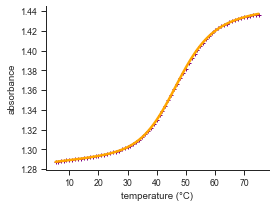

In [7]:
curve = read_curve(fn)
out = fit_param_direct(curve)
out

221106_5_SecondaryCoolingCurve
	Done!


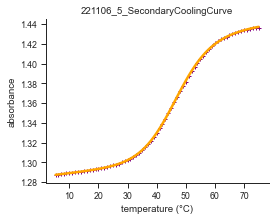

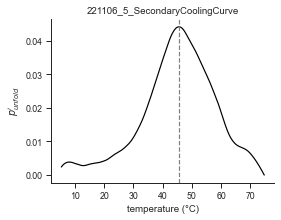

In [11]:
result_dict = fit_curve(fn, figdir=os.path.join(datadir, 'fig'), celsius_max=75)

In [286]:
result_df.append(result_dict, ignore_index=True)

,curve_date,curve_num,curve_name,dH_fit,dH_fit_std,Tm_fit,Tm_fit_std,fmax_fit,fmax_fit_std,fmin_fit,fmin_fit_std,slope_fit,slope_fit_std,Tm,dH,dS,dG_37,celsius_min,celsius_max
0,220526,1,CoolingCurve,-30.368495,0.677792,27.01489,0.065785,0.309977,0.000802,0.280776,0.000083,0.000161,0.000014,24.1,-34.119267,-0.114783,1.480702,NaN,60


In [36]:
sample_df.query("curve_date == '221106'")

,curve_date,curve_num,SEQID,conc_uM,NaConcmM,SnapFreeze,Blank,NumberOfCycles,MinTemperature,MaxTemperature,celsius_min,celsius_max,purification,Usable
ID,,,,,,,,,,,,,,


221106_7_CoolingCurve
	Done!
221106_4_SecondaryCoolingCurve
	Done!
221106_1_SecondaryMeltingCurve
	Done!
221106_6_SecondaryMeltingCurve
	Done!
221106_3_SecondaryCoolingCurve
	Done!
221106_3_CoolingCurve
	Done!
221106_6_CoolingCurve
	Done!
221106_6_SecondaryCoolingCurve
	Done!
221106_3_SecondaryMeltingCurve
	Done!
221106_4_SecondaryMeltingCurve
	Done!
221106_1_SecondaryCoolingCurve
	Done!
221106_2_CoolingCurve
	Done!
221106_5_CoolingCurve
	Done!
221106_5_SecondaryMeltingCurve
	Done!
221106_1_CoolingCurve
	Done!
221106_2_SecondaryMeltingCurve
	Done!
221106_7_SecondaryCoolingCurve
	Done!
221106_2_SecondaryCoolingCurve
	Done!
221106_4_CoolingCurve
	Done!
221106_7_SecondaryMeltingCurve
	Done!
221106_5_SecondaryCoolingCurve
	Done!


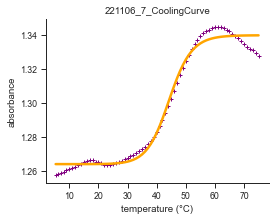

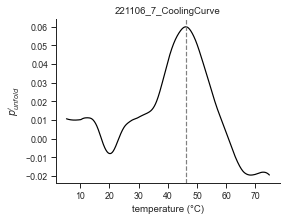

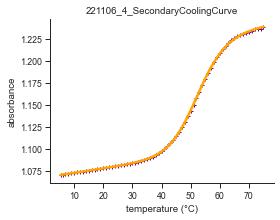

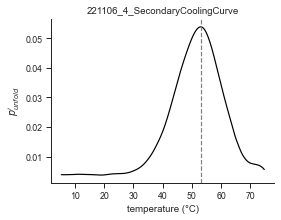

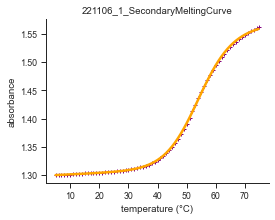

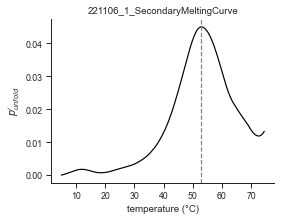

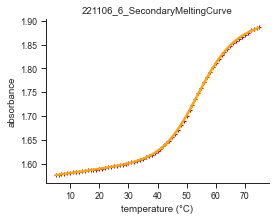

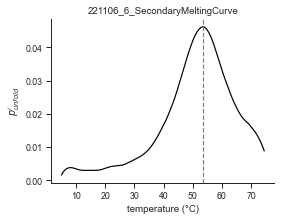

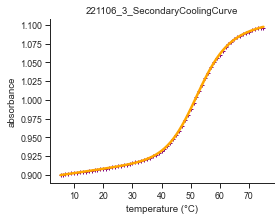

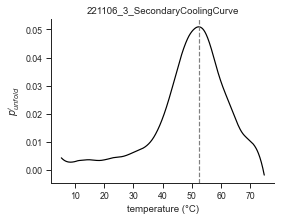

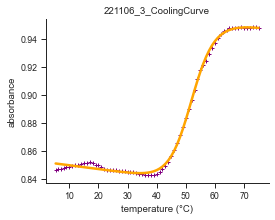

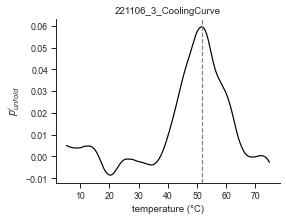

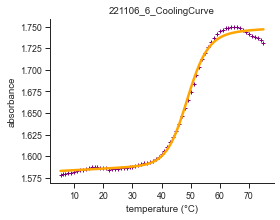

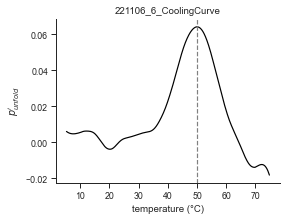

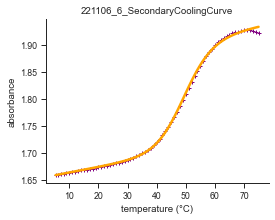

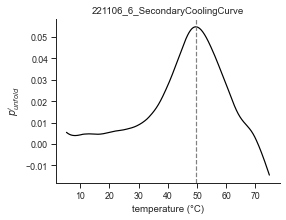

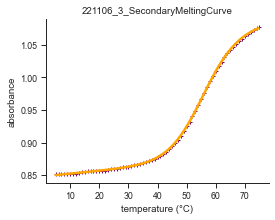

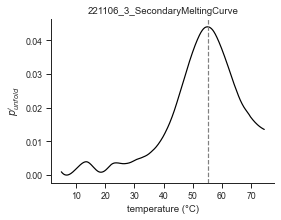

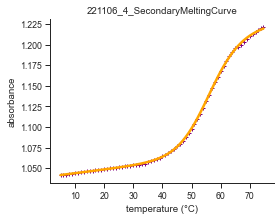

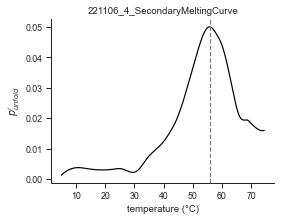

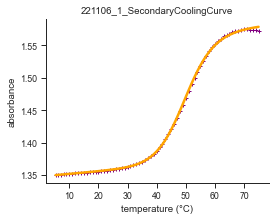

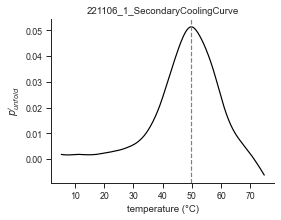

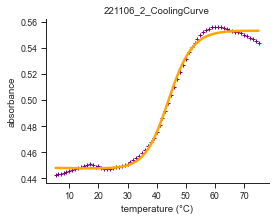

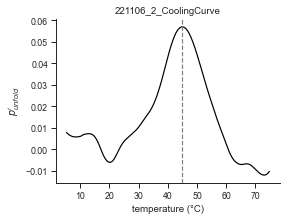

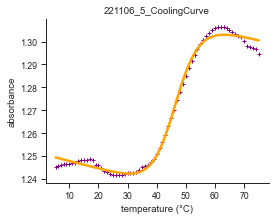

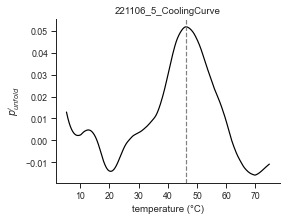

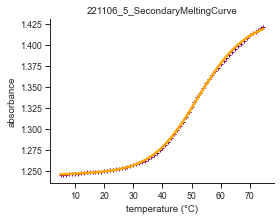

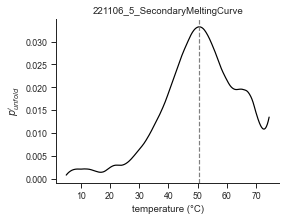

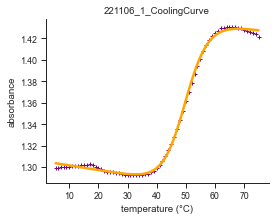

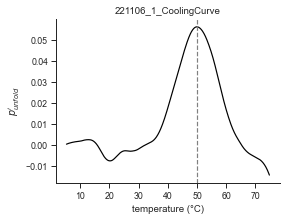

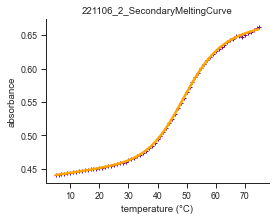

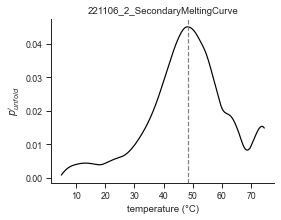

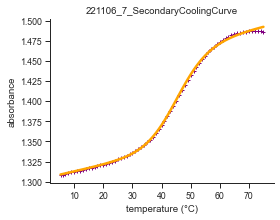

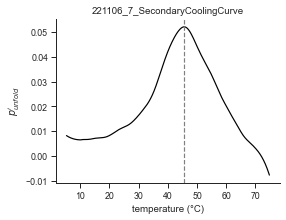

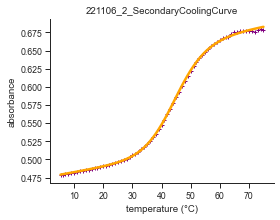

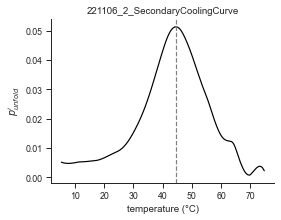

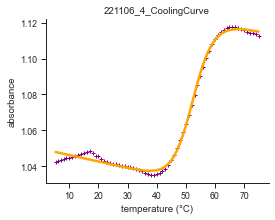

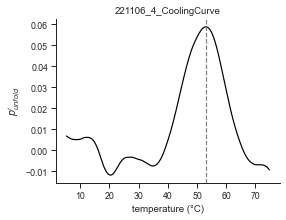

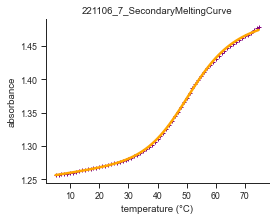

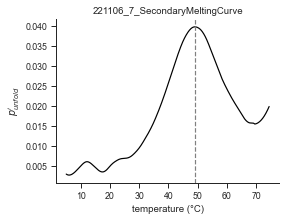

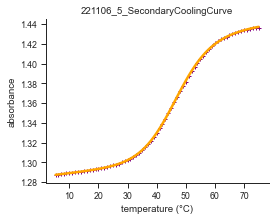

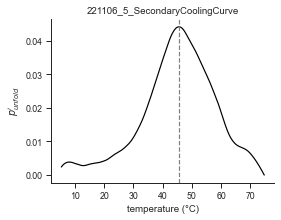

In [40]:
result_columns = ['curve_date', 'curve_num', 'curve_name',
                  'dH_fit', 'dH_fit_std', 'Tm_fit', 'Tm_fit_std', 
                  'fmax_fit', 'fmax_fit_std', 'fmin_fit', 'fmin_fit_std', 
                  'slope_fit', 'slope_fit_std', 'rmse_fit',
                  'Tm_diff', 'dH_diff', 'dS_diff', 'dG_37_diff', 
                  'celsius_min', 'celsius_max']

result_df = pd.DataFrame(index=[parse_curve_name(x)['curve_str'] for x in data_list], columns=result_columns)

for fn in data_list:
    curve_name = parse_curve_name(fn)
    # print("curve_date == '%s' & curve_num == '%s'" % (curve_name['curve_date'], curve_name['curve_num']))
    row = sample_df.query("curve_date == '%s' & curve_num == '%s'" % (curve_name['curve_date'], curve_name['curve_num']))
    
    if row.shape[0] == 0:
        print('Cannot find %s in the sample sheet' % curve_name['curve_str'])
    else:
        result_dict = fit_curve(fn, figdir=os.path.join(datadir,'fig'), 
                                celsius_min=row.at[row.index[0],'celsius_min'],
                                celsius_max=row.at[row.index[0],'celsius_max'])

        result_df.loc[curve_name['curve_str'], :] = result_dict
result_df.to_csv(os.path.join(datadir, 'uvmelt_triloop7.csv'))

In [41]:
result_df

,curve_date,curve_num,curve_name,dH_fit,dH_fit_std,Tm_fit,Tm_fit_std,fmax_fit,fmax_fit_std,fmin_fit,fmin_fit_std,slope_fit,slope_fit_std,rmse_fit,Tm_diff,dH_diff,dS_diff,dG_37_diff,celsius_min,celsius_max
221106_7_CoolingCurve,221106,7,CoolingCurve,-52.084351,5.862575,44.322478,0.316207,1.339885,0.007291,1.264179,0.001923,-0.000002,0.000106,0.003874,46.2,-48.641259,-0.152313,-1.401283,5,75
221106_4_SecondaryCoolingCurve,221106,4,SecondaryCoolingCurve,-42.860843,0.306648,52.466465,0.029384,1.202659,0.000846,1.067218,0.000215,0.000509,0.00001,0.000456,53.0,-45.534024,-0.139611,-2.233771,5,75
221106_1_SecondaryMeltingCurve,221106,1,SecondaryMeltingCurve,-36.345334,0.378294,54.311456,0.051262,1.549312,0.002433,1.298969,0.000532,0.000245,0.000027,0.001098,53.0,-38.080902,-0.116759,-1.868142,5,75
221106_6_SecondaryMeltingCurve,221106,6,SecondaryMeltingCurve,-35.166218,0.249868,54.068729,0.035461,1.832003,0.001774,1.571607,0.000376,0.000849,0.000019,0.000762,53.5,-39.169235,-0.119912,-1.978547,5,75
221106_3_SecondaryCoolingCurve,221106,3,SecondaryCoolingCurve,-40.424731,0.147357,52.287403,0.015443,1.057697,0.000534,0.89684,0.000129,0.000565,0.000006,0.000267,52.3,-42.862388,-0.131702,-2.015039,5,75
221106_3_CoolingCurve,221106,3,CoolingCurve,-53.5296,1.488036,52.033847,0.097066,0.968448,0.00246,0.852508,0.00072,-0.00027,0.000032,0.001635,51.6,-49.864246,-0.153547,-2.24178,5,75
221106_6_CoolingCurve,221106,6,CoolingCurve,-57.908935,3.256883,48.913096,0.170989,1.733192,0.00648,1.581963,0.001928,0.000183,0.000089,0.004252,50.1,-53.341176,-0.165015,-2.1617,5,75
221106_6_SecondaryCoolingCurve,221106,6,SecondaryCoolingCurve,-42.485315,1.074304,49.616908,0.094618,1.858216,0.004811,1.653781,0.001193,0.001022,0.000061,0.002377,49.6,-45.373163,-0.140583,-1.771346,5,75
221106_3_SecondaryMeltingCurve,221106,3,SecondaryMeltingCurve,-35.614547,0.257927,55.972987,0.039087,1.05339,0.001365,0.847859,0.000286,0.000438,0.000014,0.000603,55.1,-37.686247,-0.11481,-2.078054,5,75
221106_4_SecondaryMeltingCurve,221106,4,SecondaryMeltingCurve,-39.233782,0.398563,56.276299,0.051137,1.191974,0.001327,1.039403,0.000303,0.00045,0.000014,0.00067,55.8,-42.993214,-0.130698,-2.457128,5,75


In [25]:
result_df = result_df.dropna()

In [43]:
for col in ['SEQID', 'conc_uM', 'NaConcmM', 'celsius_min', 'celsius_max']:
    result_df[col] = lookup_sample_df(result_df, sample_df, col)

In [44]:
result_df['dH_ae'] = np.abs(result_df.dH_diff - result_df.dH_fit)
result_df['Tm_ae'] = np.abs(result_df.Tm_diff - result_df.Tm_fit)
result_df['dH'] = (result_df.dH_fit + result_df.dH_diff) * 0.5
result_df['Tm'] = (result_df.Tm_fit + result_df.Tm_diff) * 0.5
qc_query = 'dH_ae < 25 & Tm_ae < 10 & rmse_fit < 0.02'
result_df['pass_qc'] = result_df.eval(qc_query)

In [ ]:
tabulardir = "/Users/yuxi/Library/CloudStorage/GoogleDrive-kyx@stanford.edu/Shared drives/NNN_project/data/Tabular"

In [46]:
result_df.to_csv('./data/uv_melt/UVMeltFitResult_221106.csv')

## QC UV melting results

In [7]:
result_df = pd.read_csv('/mnt/d/data/nnn/UVMeltFitResult.csv', index_col=0)

<AxesSubplot:xlabel='rmse_fit', ylabel='Density'>

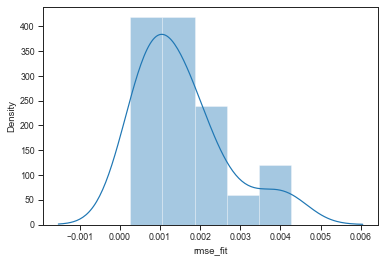

In [47]:
sns.distplot(result_df.rmse_fit)

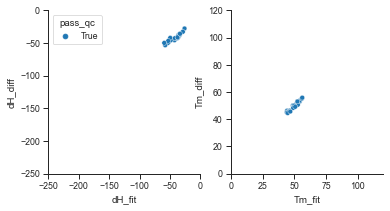

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(6,3))
sns.scatterplot(data=result_df, x='dH_fit', y='dH_diff', hue='pass_qc', ax=ax[0])
lim = (-250, 0)
ax[0].set_xlim(lim)
ax[0].set_ylim(lim)
sns.scatterplot(data=result_df, x='Tm_fit', y='Tm_diff', hue='pass_qc', ax=ax[1])
lim = (0, 120)
ax[1].set_xlim(lim)
ax[1].set_ylim(lim)
ax[1].get_legend().remove()
sns.despine()

In [31]:
result_df.query('pass_qc').to_csv('/mnt/d/data/nnn/UVMeltFitResultClean.csv')

## Comparing with data and NUPACK

In [49]:
datadir = "/Users/yuxi/Library/CloudStorage/GoogleDrive-kyx@stanford.edu/Shared drives/NNN_project/data/Tabular"

### Loading array data

This is the previous version used in 220324 notebook for WC 24plate panel design. Note that it is less stringent than the 220809 version that prepared the data for deep learning models.

86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
64.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
Load from file ./data/fitted_variant/NNNlib2b_DNA_20211022_v6.CPvariant.gz
86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
Load from file ./data/fitted_variant/NNNlib2b_DNA_20211216_v9.CPvariant.gz
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5

Combining dH

Combining Tm

Combining dG_37

Combining dS

Combining fmax

Combining fmin


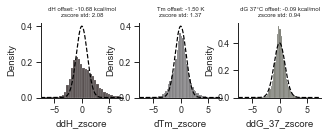

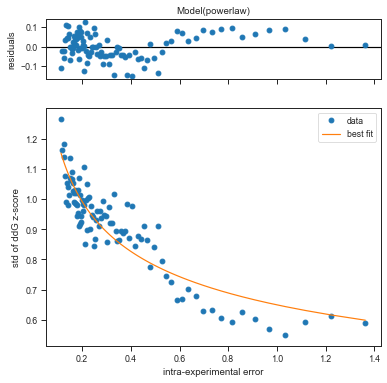

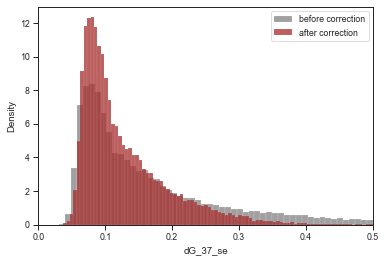

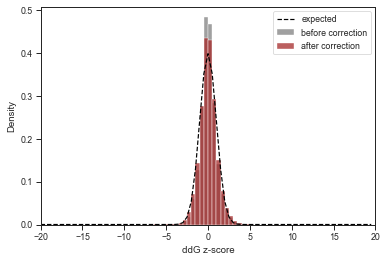

In [4]:
annotation_file = './data/annotation/NNNlib2b_annotation_20220519.tsv'
annotation = fileio.read_annotation(annotation_file)
replicate_df = pd.read_table('./data/nnnlib2b_replicates.tsv')
arraydata = ArrayData(replicate_df=replicate_df.iloc[:3,:],
                      annotation_file=annotation_file,
                      learn_error_adjust_from=('r1', 'r2'))
arr = arraydata.data.join(arraydata.annotation)

In [5]:
replicate_df

,name,replicate,chip,filename,line_fit_filename,drop_last,reverse,sodium,notes
0,r1,211022,Oct06,./data/fitted_variant/NNNlib2b_DNA_20211022_v6...,./data/fitted_variant/dG_fit_211022_v0.0.2.tsv,False,False,0.088,NaN
1,r2,211216,Nov11,./data/fitted_variant/NNNlib2b_DNA_20211216_v9...,./data/fitted_variant/dG_fit_211216_v0.0.2.tsv,False,False,0.088,NaN
2,r3,211221,Nov11,./data/fitted_variant/NNNlib2b_DNA_20211221_v9...,./data/fitted_variant/dG_fit_211221_v0.0.2.tsv,True,False,0.088,NaN
3,rev,211223,Nov11,./data/fitted_variant/NNNlib2b_DNA_20211223_v9...,./data/fitted_variant/dG_fit_211223_v0.0.2.tsv,True,True,0.088,reversed
4,salt,220314,Nov11,./data/fitted_variant/NNNlib2b_DNA_20220314_v9...,NaN,False,False,0.163,NaN


In [6]:
# This construct is not in the final deep learning input dataset!
'WC578' in arr.index

True

In [9]:
arr.to_csv(os.path.join(datadir, 'arr_v0.csv'))

### Making some plots

In [59]:
arr = pd.read_csv(os.path.join(datadir, 'arr.csv')).set_index('SEQID')
result_df = pd.read_csv(os.path.join(datadir, 'UVMeltFitResult_221106.csv'), index_col=0)

In [60]:
'WC1048' in arr.index

True

In [61]:
result_df['dG_37'] = util.get_dG(result_df['dH'], result_df['Tm'], celsius=37)
result_df['dS'] = result_df['dH'] / result_df['Tm']

In [63]:
agg_stat = ['mean', 'std']
result_agg_df = result_df.groupby(['SEQID', 'conc_uM', 'NaConcmM']).agg(dict(dH=agg_stat, Tm=agg_stat, dG_37=agg_stat, dS=agg_stat)).reset_index()

result_agg_df.columns = [f'{x[0]}_{x[1]}'.strip('_').replace('mean', 'uv') for x in result_agg_df.columns]

result_agg_df['is_hairpin'] = True
result_agg_df.loc[result_agg_df['SEQID'] == 'WC1025_stem', 'is_hairpin'] = False
result_agg_df.loc[result_agg_df['SEQID'] == 'WC1025_stem', 'SEQID']  = 'WC1025'

result_agg_df = result_agg_df.fillna(0)

result_agg_df.to_csv(os.path.join(datadir, 'UVMeltFitResultAgg.csv'))

In [64]:
df = result_agg_df.merge(arr, how='left', on='SEQID', suffixes=('_uv', ''))

In [65]:
df.to_csv(os.path.join(datadir, 'UVMeltFitResultAggMerged_221106.csv'))

In [66]:
df.sort_values('dG_37_std', ascending=False)

,SEQID,conc_uM,NaConcmM,dH_uv,dH_std,Tm_uv,Tm_std,dG_37_uv,dG_37_std,dS_uv,...,TargetStruct,dG_37_NUPACK,dG_37_ensemble_150mM_NUPACK,dG_37_ensemble_75mM_NUPACK,GC,Tm_NUPACK_salt_corrected,dG_37_NUPACK_salt_corrected,dH_NUPACK_salt_corrected,dS_NUPACK_salt_corrected,scaffold
3,TRINNN470,9.0,25.0,-46.635134,7.063352,53.837946,1.905438,-2.382921,0.251753,-0.868972,...,((((((...)))))),-2.56,-2.470385,-2.138154,46.666667,46.557588,-1.183833,-39.6,-0.119426,GATCGATC_nan
5,TRINNN520,9.0,25.0,-45.574007,9.337944,50.966455,2.440913,-1.926771,0.220597,-0.900053,...,((((((...)))))),-3.40,-3.293370,-2.944688,46.666667,53.776898,-2.062942,-40.2,-0.118652,GATCGATC_nan
2,TRINNN452,9.0,25.0,-43.330293,7.663764,53.215706,2.023949,-2.127009,0.206735,-0.817986,...,((((((...)))))),-2.56,-2.483851,-2.156781,40.000000,46.035858,-1.121040,-39.6,-0.119426,GATCGATC_nan
4,TRINNN512,9.0,25.0,-35.810928,9.522516,48.106036,3.107881,-1.189077,0.174922,-0.752945,...,((((((...)))))),-3.40,-3.293946,-2.945449,40.000000,53.255168,-2.001983,-40.2,-0.118652,GATCGATC_nan
1,TRINNN445,9.0,25.0,-40.756050,6.065594,45.994208,2.376891,-1.124783,0.171310,-0.891042,...,((((((...)))))),-2.71,-2.518433,-2.172343,53.333333,48.243801,-1.395881,-39.9,-0.119910,GATCGATC_nan
0,TRINNN162,9.0,25.0,-43.121008,6.324458,51.151876,2.169365,-1.859236,0.160608,-0.846686,...,((((((...)))))),-2.71,-2.607211,-2.266792,53.333333,48.243801,-1.395881,-39.9,-0.119910,GATCGATC_nan
6,TRINNN544,9.0,25.0,-40.256421,9.780006,46.933484,2.597911,-1.203216,0.121728,-0.865955,...,((((((...)))))),-3.40,-3.294824,-2.946805,46.666667,53.776898,-2.062942,-40.2,-0.118652,GATCGATC_nan


UndefinedVariableError: name 'Na_mM' is not defined

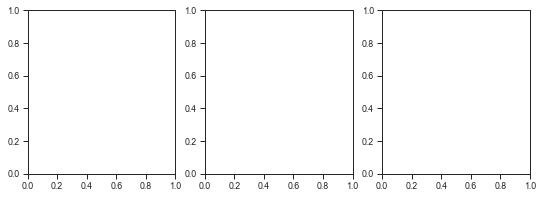

In [67]:
plot_query = 'Na_mM <=2000'
kwargs = dict(palette='Set1')
fig, ax = plt.subplots(1, 3, figsize=(9,3))
sns.scatterplot(data=df.query(plot_query), x='dH_uv', y='dH', hue='Na_mM', 
                ax=ax[0], **kwargs)
lim = (-60, -30)
ax[0].set_xlim(lim)
ax[0].set_ylim(lim)
sns.scatterplot(data=df.query(plot_query), x='Tm_uv', y='Tm', hue='Na_mM', 
                ax=ax[1], **kwargs)
lim = (35, 60)
ax[1].set_xlim(lim)
ax[1].set_ylim(lim)
ax[1].get_legend().remove()

sns.scatterplot(data=df.query(plot_query), x='dG_37_uv', y='dG_37', hue='Na_mM', 
                ax=ax[2], **kwargs)
lim = (-5, 1)
ax[2].set_xlim(lim)
ax[2].set_ylim(lim)
ax[2].get_legend().remove()

sns.despine()

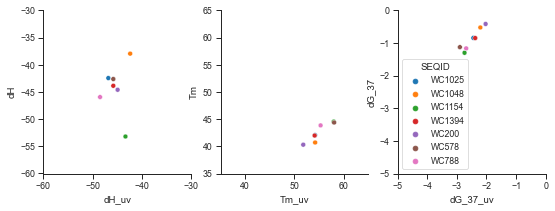

In [231]:
plot_query = 'Na_mM == 25 & is_hairpin'
#df = df.reset_index()
kwargs = dict(palette='tab10', hue='SEQID')

fig, ax = plt.subplots(1, 3, figsize=(9,3))
sns.scatterplot(data=df.query(plot_query), x='dH_uv', y='dH', 
                ax=ax[0], **kwargs)
lim = (-60, -30)
ax[0].set_xlim(lim)
ax[0].set_ylim(lim)
sns.scatterplot(data=df.query(plot_query), x='Tm_uv', y='Tm',
                ax=ax[1], **kwargs)
ax[0].get_legend().remove()

lim = (35, 65)
ax[1].set_xlim(lim)
ax[1].set_ylim(lim)
ax[1].get_legend().remove()

sns.scatterplot(data=df.query(plot_query), x='dG_37_uv', y='dG_37',
                ax=ax[2], **kwargs)
lim = (-5, 0)
ax[2].set_xlim(lim)
ax[2].set_ylim(lim)
#ax[2].get_legend().remove()

sns.despine()

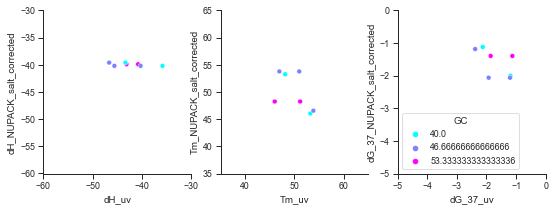

In [70]:
plot_query = 'is_hairpin'

kwargs = dict(palette='cool', hue='GC')

fig, ax = plt.subplots(1, 3, figsize=(9,3))
sns.scatterplot(data=df.query(plot_query), x='dH_uv', y='dH_NUPACK_salt_corrected', 
                ax=ax[0], **kwargs)
lim = (-60, -30)
ax[0].set_xlim(lim)
ax[0].set_ylim(lim)
sns.scatterplot(data=df.query(plot_query), x='Tm_uv', y='Tm_NUPACK_salt_corrected',
                ax=ax[1], **kwargs)
ax[0].get_legend().remove()

lim = (35, 65)
ax[1].set_xlim(lim)
ax[1].set_ylim(lim)
ax[1].get_legend().remove()

sns.scatterplot(data=df.query(plot_query), x='dG_37_uv', y='dG_37_NUPACK_salt_corrected',
                ax=ax[2], **kwargs)
lim = (-5, 0)
ax[2].set_xlim(lim)
ax[2].set_ylim(lim)
#ax[2].get_legend().remove()

sns.despine()

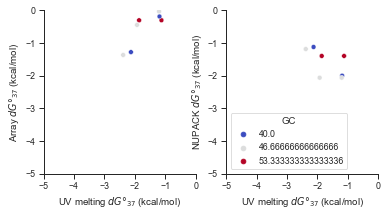

In [71]:
plot_query = 'is_hairpin'

kwargs = dict(palette='coolwarm', hue='GC')

fig, ax = plt.subplots(1, 2, figsize=(6,3), sharex=True)
sns.scatterplot(data=df.query(plot_query), x='dG_37_uv', y='dG_37', 
                ax=ax[0], **kwargs)
lim = (-5, 0)
ax[0].set_xlim(lim)
ax[0].set_ylim(lim)
ax[0].set_xlabel(r'UV melting $dG°_{37}$ (kcal/mol)')
ax[0].set_ylabel(r'Array $dG°_{37}$ (kcal/mol)')

sns.scatterplot(data=df.query(plot_query), x='dG_37_uv', y='dG_37_NUPACK_salt_corrected',
                ax=ax[1], **kwargs)
ax[0].get_legend().remove()

ax[1].set_xlim(lim)
ax[1].set_ylim(lim)
ax[1].set_xlabel(r'UV melting $dG°_{37}$ (kcal/mol)')
ax[1].set_ylabel(r'NUPACK $dG°_{37}$ (kcal/mol)')
#ax[1].get_legend().remove()

sns.despine()

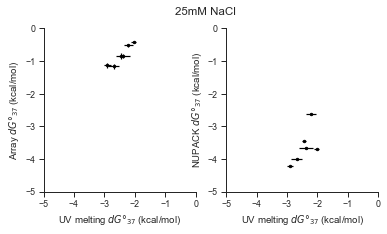

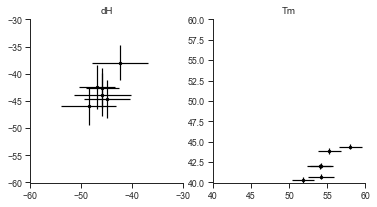

In [18]:
plot_query = 'Na_mM == 25 & is_hairpin & dG_37_std < .5'
df_q = df.query(plot_query)

fig, ax = plt.subplots(1, 2, figsize=(6,3), sharex=True)
ax[0].errorbar(df_q['dG_37_uv'], df_q['dG_37'],
               xerr=df_q['dG_37_std'], yerr=df_q['dG_37_se'],
               fmt='k.')
lim = (-5, 0)
ax[0].set_xlim(lim)
ax[0].set_ylim(lim)
ax[0].set_xlabel(r'UV melting $dG°_{37}$ (kcal/mol)')
ax[0].set_ylabel(r'Array $dG°_{37}$ (kcal/mol)')

ax[1].errorbar(df_q['dG_37_uv'], df_q['dG_37_NUPACK_salt_corrected'],
               xerr=df_q['dG_37_std'],
               fmt='k.')

ax[1].set_xlim(lim)
ax[1].set_ylim(lim)
ax[1].set_xlabel(r'UV melting $dG°_{37}$ (kcal/mol)')
ax[1].set_ylabel(r'NUPACK $dG°_{37}$ (kcal/mol)')
#ax[1].get_legend().remove()
plt.suptitle('25mM NaCl')
sns.despine()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(6,3))
ax[0].errorbar(df_q['dH_uv'], df_q['dH'],
               xerr=df_q['dH_std'], yerr=df_q['dH_se'],
               fmt='k.')
lim = (-60, -30)
ax[0].set_xlim(lim)
ax[0].set_ylim(lim)
ax[0].set_title('dH')

ax[1].errorbar(df_q['Tm_uv'], df_q['Tm'],
               xerr=df_q['Tm_std'], yerr=df_q['Tm_se'],
               fmt='k.')
lim = (40, 60)
ax[1].set_xlim(lim)
ax[1].set_ylim(lim)
ax[1].set_title('Tm')
sns.despine()

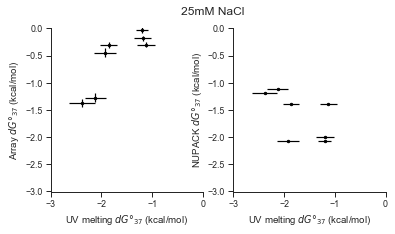

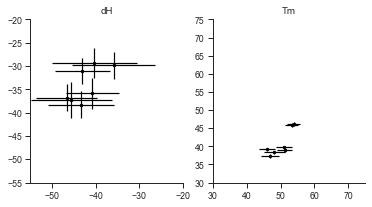

In [83]:
plot_query = 'is_hairpin'
df_q = df.query(plot_query)

fig, ax = plt.subplots(1, 2, figsize=(6,3), sharex=True)
ax[0].errorbar(df_q['dG_37_uv'], df_q['dG_37'],
               xerr=df_q['dG_37_std'], yerr=df_q['dG_37_se'],
               fmt='k.')
lim = (-3, 0)
ax[0].set_xlim(lim)
ax[0].set_ylim(lim)
ax[0].set_xlabel(r'UV melting $dG°_{37}$ (kcal/mol)')
ax[0].set_ylabel(r'Array $dG°_{37}$ (kcal/mol)')

ax[1].errorbar(df_q['dG_37_uv'], df_q['dG_37_NUPACK_salt_corrected'],
               xerr=df_q['dG_37_std'],
               fmt='k.')

ax[1].set_xlim(lim)
ax[1].set_ylim(lim)
ax[1].set_xlabel(r'UV melting $dG°_{37}$ (kcal/mol)')
ax[1].set_ylabel(r'NUPACK $dG°_{37}$ (kcal/mol)')
#ax[1].get_legend().remove()
plt.suptitle('25mM NaCl')
sns.despine()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(6,3))
ax[0].errorbar(df_q['dH_uv'], df_q['dH'],
               xerr=df_q['dH_std'], yerr=df_q['dH_se'],
               fmt='k.')
lim = (-55, -20)
ax[0].set_xlim(lim)
ax[0].set_ylim(lim)
ax[0].set_title('dH')

ax[1].errorbar(df_q['Tm_uv'], df_q['Tm'],
               xerr=df_q['Tm_std'], yerr=df_q['Tm_se'],
               fmt='k.')
lim = (30, 75)
ax[1].set_xlim(lim)
ax[1].set_ylim(lim)
ax[1].set_title('Tm')
sns.despine()

In [19]:
plot_query = 'Na_mM == 25 & is_hairpin & dG_37_std < .5'
df_q = df.query(plot_query)

param = 'Tm'
ols_Tm = LinearRegressionSVD(param=param)
ols_Tm.fit(util.add_intercept(df_q[param].values.reshape(-1,1)), df_q[param+'_uv'].values.reshape(-1,1), df_q[param+'_std'].values.reshape(-1,1))

param = 'dG_37'
ols_dG_37 = LinearRegressionSVD(param=param)
ols_dG_37.fit(util.add_intercept(df_q[param].values.reshape(-1,1)), df_q[param+'_uv'].values.reshape(-1,1), df_q[param+'_std'].values.reshape(-1,1))

print(ols_Tm.coef_, ols_dG_37.coef_)
print(ols_Tm.coef_se_, ols_dG_37.coef_se_)
correction = dict(Tm=ols_Tm.coef_, dG_37=ols_dG_37.coef_)

[1.13841753 6.500247  ] [ 1.07326442 -1.57304008]
[ 0.41852742 17.67287746] [0.16025386 0.13086592]


In [487]:
plot_query = 'Na_mM == 25 & is_hairpin & dG_37_std < .5'
df_q = df.query(plot_query)

ols_Tm = fit_param_offset(df_q, 'Tm', fix_slope=True, adjusted=False)
ols_dG_37 = fit_param_offset(df_q, 'dG_37', fix_slope=True, adjusted=False)
print(ols_Tm.coef_, ols_dG_37.coef_)
correction = dict(Tm=ols_Tm.coef_, dG_37=ols_dG_37.coef_)

[ 1.         12.38768258] [ 1.         -1.62264337]


In [492]:
import pickle

with open('./data/uv_melt/correction.pkl', 'wb') as fh:
    pickle.dump(correction, fh)

In [485]:
plot_query = 'Na_mM == 25 & is_hairpin & dG_37_std < .5'
df_q = df.query(plot_query)

df_q['dG_50'] = get_dG(df_q['dH'], df_q['Tm'], 90)
df_q['dG_50_std'] = df_q['dG_37_std']
df_q['dG_50_uv'] = get_dG(df_q['dH_uv'], df_q['Tm_uv'], 90)

ols_dG_50 = fit_param_offset(df_q, 'dG_50', fix_slope=True, adjusted=False)
print(ols_dG_50.coef_)
correction['dG_50'] = ols_dG_50.coef_

[ 1.         -1.56263511]


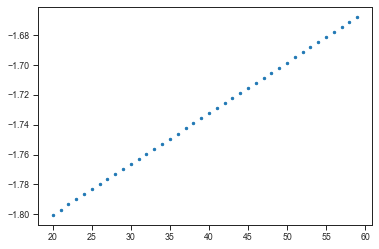

In [483]:
def get_dG_correction_celsius(df, celsius):
    plot_query = 'Na_mM == 25 & is_hairpin & dG_37_std < .5'
    df_q = df.query(plot_query)
    df_q['dG_%d'%celsius] = get_dG(df_q['dH'], df_q['Tm'], celsius)
    df_q['dG_%d_std'%celsius] = df_q['dG_37_std']
    df_q['dG_%d_uv'%celsius] = get_dG(df_q['dH_uv'], df_q['Tm_uv'], celsius)

    ols_dG = fit_param_offset(df_q, 'dG_%d'%celsius, fix_slope=True, adjusted=False)

    return ols_dG.coef_[1]

T = np.arange(20, 60)
offset = np.zeros_like(T).astype(float)
for i,t in enumerate(T):
    offset[i] = get_dG_correction_celsius(df, t)
plt.plot(T, offset, '.')

In [29]:
df.columns

Index(['SEQID', 'conc_uM', 'Na_mM', 'dH_uv', 'dH_std', 'Tm_uv', 'Tm_std',
       'dG_37_uv', 'dG_37_std', 'dS_uv', 'dS_std', 'is_hairpin', 'dH', 'dH_se',
       'dH_lb', 'dH_ub', 'Tm', 'Tm_se', 'Tm_lb', 'Tm_ub', 'dG_37', 'dG_37_se',
       'dG_37_lb', 'dG_37_ub', 'dS', 'dS_se', 'dS_lb', 'dS_ub', 'fmax',
       'fmax_se', 'fmax_lb', 'fmax_ub', 'fmin', 'fmin_se', 'fmin_lb',
       'fmin_ub', 'Series', 'ConstructType', 'bottomScaffold', 'topScaffold',
       'RefSeq', 'dH_NUPACK', 'dS_NUPACK', 'Tm_NUPACK',
       'dG_37_ensemble_NUPACK', 'TargetStruct', 'dG_37_NUPACK',
       'dG_37_ensemble_150mM_NUPACK', 'dG_37_ensemble_75mM_NUPACK', 'GC',
       'Tm_NUPACK_salt_corrected', 'dG_37_NUPACK_salt_corrected',
       'dH_NUPACK_salt_corrected', 'dS_NUPACK_salt_corrected', 'dG_25',
       'dG_25_std', 'dG_25_uv', 'dG_37_corrected'],
      dtype='object')

In [31]:
df['dG_25'] = get_dG(df['dH'], df['Tm'], 25)
df['dG_25_std'] = df['dG_37_std']
df['dG_25_uv'] = get_dG(df['dH_uv'], df['Tm_uv'], 25)

df['dG_37_corrected'] = correct_param(df, correction, 'dG_37')
# df['dG_25_corrected'] = correct_param(df, correction, 'dG_25')
# df['dS_corrected'] = (- df['dG_37_corrected'] + df['dG_25_corrected']) / (37 - 25)
# df['dH_corrected'] = df['dG_37_corrected'] + (37 + C2T) * df['dS_corrected']

In [423]:
df[['dG_25', 'dG_25_corrected', 'dH', 'dH_corrected']]

,dG_25,dG_25_corrected,dH,dH_corrected
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,-2.297732,-4.081019,-42.444102,-44.229555
3,-2.297732,-4.081019,-42.444102,-44.229555
4,-2.297732,-4.081019,-42.444102,-44.229555
5,-2.297732,-4.081019,-42.444102,-44.229555
6,-1.898783,-3.682070,-37.950439,-41.861718
7,-1.898783,-3.682070,-37.950439,-41.861718
8,-1.898783,-3.682070,-37.950439,-41.861718
9,-2.926216,-4.709504,-47.549908,-46.766785


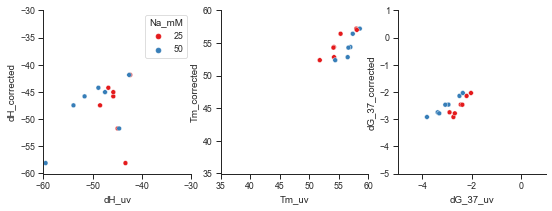

In [425]:
plot_query = 'Na_mM <=50'
kwargs = dict(palette='Set1')
fig, ax = plt.subplots(1, 3, figsize=(9,3))
sns.scatterplot(data=df.query(plot_query), x='dH_uv', y='dH_corrected', hue='Na_mM', 
                ax=ax[0], **kwargs)
lim = (-60, -30)
ax[0].set_xlim(lim)
ax[0].set_ylim(lim)
sns.scatterplot(data=df.query(plot_query), x='Tm_uv', y='Tm_corrected', hue='Na_mM', 
                ax=ax[1], **kwargs)
lim = (35, 60)
ax[1].set_xlim(lim)
ax[1].set_ylim(lim)
ax[1].get_legend().remove()

sns.scatterplot(data=df.query(plot_query), x='dG_37_uv', y='dG_37_corrected', hue='Na_mM', 
                ax=ax[2], **kwargs)
lim = (-5, 1)
ax[2].set_xlim(lim)
ax[2].set_ylim(lim)
ax[2].get_legend().remove()

sns.despine()

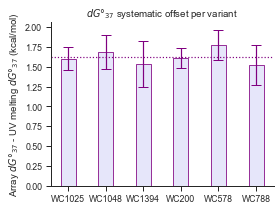

In [461]:
plt.figure(figsize=(4,3))
plt.bar(df_q['SEQID'], df_q['dG_37'] - df_q['dG_37_uv'], 
        yerr=df_q['dG_37_se'] + df_q['dG_37_std'],
        fc='lavender', width=0.4, edgecolor='purple', ecolor='purple', capsize=5)
plt.axhline(y=-correction['dG_37'][1], c='purple', linestyle=':')
plt.ylabel(r'Array $dG°_{37}$ - UV melting $dG°_{37}$ (kcal/mol)')
plt.title(r'$dG°_{37}$ systematic offset per variant')
sns.despine()
util.save_fig('./fig/UV_melt/dG_37_offset_per_variant.pdf')

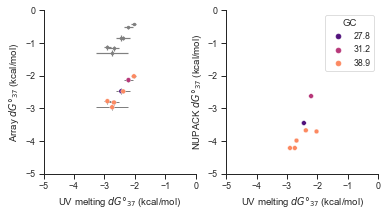

In [33]:
plot_query = 'Na_mM == 25 & is_hairpin'
df_q = df.query(plot_query)
df_q['GC'] = df_q['GC'].apply(lambda x: '%.1f'%x)
kwargs = dict(palette='magma', hue='GC')

fig, ax = plt.subplots(1, 2, figsize=(6,3), sharex=True)
ax[0].errorbar(df_q['dG_37_uv'], df_q['dG_37'],
               xerr=df_q['dG_37_std'], yerr=df_q['dG_37_se'],
               fmt='.', c='gray')
ax[0].errorbar(df_q['dG_37_uv'], df_q['dG_37_corrected'],
               xerr=df_q['dG_37_std'], yerr=df_q['dG_37_se'],
               fmt='.', c='k', linewidth=0.5, zorder=0)
sns.scatterplot(data=df_q, x='dG_37_uv', y='dG_37_corrected',
                ax=ax[0], **kwargs)

lim = (-5, 0)
ax[0].set_xlim(lim)
ax[0].set_ylim(lim)
ax[0].set_xlabel(r'UV melting $dG°_{37}$ (kcal/mol)')
ax[0].set_ylabel(r'Array $dG°_{37}$ (kcal/mol)')
sns.scatterplot(data=df_q, x='dG_37_uv', y='dG_37_NUPACK_salt_corrected',
                ax=ax[1], **kwargs)
ax[0].get_legend().remove()

ax[1].set_xlim(lim)
ax[1].set_ylim(lim)
ax[1].set_xlabel(r'UV melting $dG°_{37}$ (kcal/mol)')
ax[1].set_ylabel(r'NUPACK $dG°_{37}$ (kcal/mol)')

#ax[1].get_legend().remove()

sns.despine()

util.save_fig('./fig/UV_melt/25mM_NaCl_dG_37_correction.pdf')

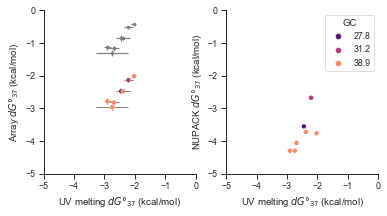

In [381]:
plot_query = 'Na_mM == 25 & is_hairpin'
df_q = df.query(plot_query)
df_q['GC'] = df_q['GC'].apply(lambda x: '%.1f'%x)
kwargs = dict(palette='magma', hue='GC')

fig, ax = plt.subplots(1, 2, figsize=(6,3), sharex=True)
ax[0].errorbar(df_q['dG_37_uv'], df_q['dG_37'],
               xerr=df_q['dG_37_std'], yerr=df_q['dG_37_se'],
               fmt='.', c='gray')
ax[0].errorbar(df_q['dG_37_uv'], df_q['dG_37_corrected'],
               xerr=df_q['dG_37_std'], yerr=df_q['dG_37_se'],
               fmt='.', c='k', linewidth=0.5, zorder=0)
sns.scatterplot(data=df_q, x='dG_37_uv', y='dG_37_corrected',
                ax=ax[0], **kwargs)

lim = (-5, 0)
ax[0].set_xlim(lim)
ax[0].set_ylim(lim)
ax[0].set_xlabel(r'UV melting $dG°_{37}$ (kcal/mol)')
ax[0].set_ylabel(r'Array $dG°_{37}$ (kcal/mol)')
sns.scatterplot(data=df_q, x='dG_37_uv', y='dG_37_NUPACK_salt_corrected',
                ax=ax[1], **kwargs)
ax[0].get_legend().remove()

ax[1].set_xlim(lim)
ax[1].set_ylim(lim)
ax[1].set_xlabel(r'UV melting $dG°_{37}$ (kcal/mol)')
ax[1].set_ylabel(r'NUPACK $dG°_{37}$ (kcal/mol)')

#ax[1].get_legend().remove()

sns.despine()

util.save_fig('./fig/UV_melt/25mM_NaCl_dG_37_correction.pdf')

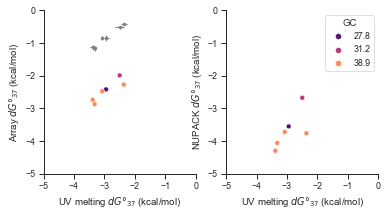

In [368]:
plot_query = 'Na_mM == 50 & is_hairpin & dG_37_std < 0.5'
df_q = df.query(plot_query)

df_q['dG_37_adjusted'] = util.get_Na_adjusted_dG_37(df_q['Tm_corrected'], df_q['dH'], df_q['GC'], Na=0.088+0.025, from_Na=0.088)
df_q['GC'] = df_q['GC'].apply(lambda x: '%.1f'%x)
kwargs = dict(palette='magma', hue='GC')

fig, ax = plt.subplots(1, 2, figsize=(6,3), sharex=True)
ax[0].errorbar(df_q['dG_37_uv'], df_q['dG_37'],
               xerr=df_q['dG_37_std'], yerr=df_q['dG_37_se'],
               fmt='.', c='gray')
sns.scatterplot(data=df_q, x='dG_37_uv', y='dG_37_adjusted', 
                ax=ax[0], **kwargs)
lim = (-5, 0)
ax[0].set_xlim(lim)
ax[0].set_ylim(lim)
ax[0].set_xlabel(r'UV melting $dG°_{37}$ (kcal/mol)')
ax[0].set_ylabel(r'Array $dG°_{37}$ (kcal/mol)')
sns.scatterplot(data=df_q, x='dG_37_uv', y='dG_37_NUPACK_salt_corrected',
                ax=ax[1], **kwargs)
ax[0].get_legend().remove()

ax[1].set_xlim(lim)
ax[1].set_ylim(lim)
ax[1].set_xlabel(r'UV melting $dG°_{37}$ (kcal/mol)')
ax[1].set_ylabel(r'NUPACK $dG°_{37}$ (kcal/mol)')

#ax[1].get_legend().remove()

sns.despine()

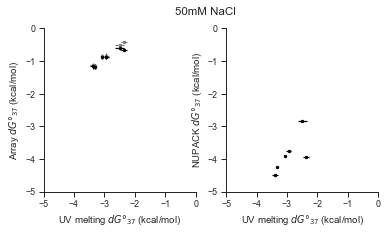

In [333]:
df_q = df.query('Na_mM == 50 & is_hairpin & dG_37_std < .5')
df_q['Tm_adjusted'] = util.get_Na_adjusted_Tm(df_q['Tm'], df_q['dH'], df_q['GC'], Na=0.088+0.025, from_Na=0.088)
df_q['dG_37_adjusted'] = util.get_Na_adjusted_dG_37(df_q['Tm'], df_q['dH'], df_q['GC'], Na=0.088+0.025, from_Na=0.088)
df_q['dG_37_NUPACK_adjusted'] = util.get_Na_adjusted_dG_37(df_q['Tm_NUPACK'], df_q['dH_NUPACK'], df_q['GC'], Na=0.088+0.025, from_Na=1)

fig, ax = plt.subplots(1, 2, figsize=(6,3), sharex=True)
ax[0].errorbar(df_q['dG_37_uv'], df_q['dG_37'],
               xerr=df_q['dG_37_std'], yerr=df_q['dG_37_se'],
               fmt='.', c='gray')
ax[0].errorbar(df_q['dG_37_uv'], df_q['dG_37_adjusted'],
               xerr=df_q['dG_37_std'], yerr=df_q['dG_37_se'],
               fmt='k.')
lim = (-5, 0)
ax[0].set_xlim(lim)
ax[0].set_ylim(lim)
ax[0].set_xlabel(r'UV melting $dG°_{37}$ (kcal/mol)')
ax[0].set_ylabel(r'Array $dG°_{37}$ (kcal/mol)')

# ax[1].errorbar(df_q['dG_37_uv'], df_q['dG_37_NUPACK'],
#                xerr=df_q['dG_37_std'],
#                fmt='.', c='gray')
ax[1].errorbar(df_q['dG_37_uv'], df_q['dG_37_NUPACK_adjusted'],
               xerr=df_q['dG_37_std'],
               fmt='k.')

ax[1].set_xlim(lim)
ax[1].set_ylim(lim)
ax[1].set_xlabel(r'UV melting $dG°_{37}$ (kcal/mol)')
ax[1].set_ylabel(r'NUPACK $dG°_{37}$ (kcal/mol)')
#ax[1].get_legend().remove()
plt.suptitle('50mM NaCl')
sns.despine()

In [334]:
ols_Tm = fit_param_offset(df_q, 'Tm', fix_slope=True)
ols_dG_37 = fit_param_offset(df_q, 'dG_37', fix_slope=True)
print(ols_Tm.coef_, ols_dG_37.coef_)

[ 1.         13.60167631] [ 1.         -2.04345605]


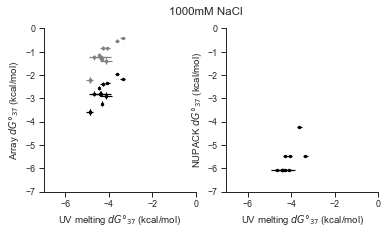

In [335]:
df_q = df.query('Na_mM == 1000 & is_hairpin & dG_37_std < .5')
df_q['Tm_adjusted'] = util.get_Na_adjusted_Tm(df_q['Tm'], df_q['dH'], df_q['GC'], Na=1, from_Na=0.088)
df_q['dG_37_adjusted'] = util.get_Na_adjusted_dG_37(df_q['Tm'], df_q['dH'], df_q['GC'], Na=1, from_Na=0.088)

fig, ax = plt.subplots(1, 2, figsize=(6,3), sharex=True)
ax[0].errorbar(df_q['dG_37_uv'], df_q['dG_37'],
               xerr=df_q['dG_37_std'], yerr=df_q['dG_37_se'],
               fmt='.', c='gray')
ax[0].errorbar(df_q['dG_37_uv'], df_q['dG_37_adjusted'],
               xerr=df_q['dG_37_std'], yerr=df_q['dG_37_se'],
               fmt='k.')
lim = (-7, 0)
ax[0].set_xlim(lim)
ax[0].set_ylim(lim)
ax[0].set_xlabel(r'UV melting $dG°_{37}$ (kcal/mol)')
ax[0].set_ylabel(r'Array $dG°_{37}$ (kcal/mol)')

ax[1].errorbar(df_q['dG_37_uv'], df_q['dG_37_NUPACK'],
               xerr=df_q['dG_37_std'],
               fmt='k.')

ax[1].set_xlim(lim)
ax[1].set_ylim(lim)
ax[1].set_xlabel(r'UV melting $dG°_{37}$ (kcal/mol)')
ax[1].set_ylabel(r'NUPACK $dG°_{37}$ (kcal/mol)')
#ax[1].get_legend().remove()
plt.suptitle('1000mM NaCl')
sns.despine()

In [340]:
from nnn.uv import fit_param_offset
ols_Tm = fit_param_offset(df_q, 'Tm', fix_slope=True)
ols_dG_37 = fit_param_offset(df_q, 'dG_37', fix_slope=True)
print(ols_Tm.coef_, ols_dG_37.coef_)

[ 1.         11.26171651] [ 1.         -1.52221695]


<AxesSubplot: xlabel='SEQID', ylabel='dG_37_uv'>

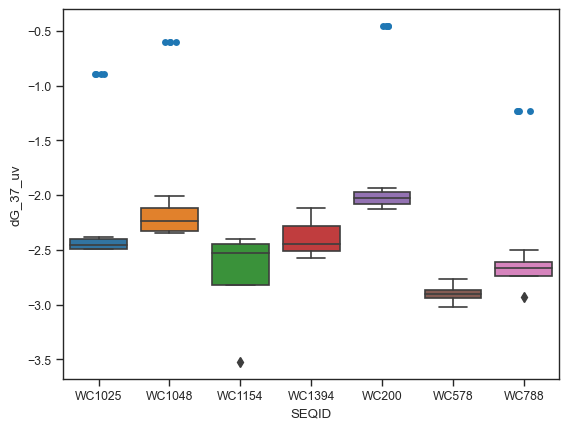

In [93]:
sns.boxplot(data=df.query(plot_query), x='SEQID', y='dG_37_uv')
sns.stripplot(data=df.query(plot_query), x='SEQID', y='dG_37')

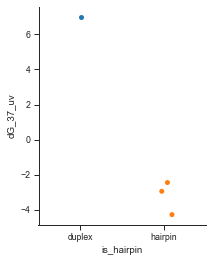

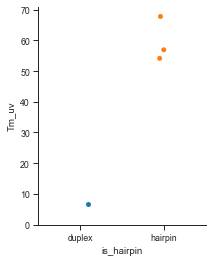

In [519]:
fig, ax = plt.subplots(figsize=(3,4))
sns.stripplot(data=df.query('SEQID == "WC1025"'), x='is_hairpin', y='dG_37_uv')
#sns.stripplot(data=df.query('SEQID == "WC1025"'), x='is_hairpin', y='dG_37', palette='magma')
ax.set_xticklabels(['duplex', 'hairpin'])
sns.despine()
util.save_fig('./fig/UV_melt/WC1025_duplex_dG_37.pdf')

fig, ax = plt.subplots(figsize=(3,4))
sns.stripplot(data=df.query('SEQID == "WC1025"'), x='is_hairpin', y='Tm_uv')
ax.set_xticklabels(['duplex', 'hairpin'])
ax.set_ylim(bottom=0)
sns.despine()
util.save_fig('./fig/UV_melt/WC1025_duplex_Tm.pdf')

In [502]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))
qc_criterion = 'rmse_fit < 0.015 & dH_fit_std < 10 & Tm_fit_std < 5 & dH_relabsdiff < 20 & Tm_relabsdiff < 10'
sns.scatterplot(data=result_df, 
                x='dH_relabsdiff', y='Tm_relabsdiff', color='gray',
                ax=ax[0])
sns.scatterplot(data=result_df.query(qc_criterion), 
                x='dH_relabsdiff', y='Tm_relabsdiff', color='salmon',
                ax=ax[0])
ax[0].axhline(10, linestyle='--', c='gray')
ax[0].axvline(20, linestyle='--', c='gray')

sns.scatterplot(data=result_df, 
                x='rmse_fit', y='dH_fit_std', color='gray',
                ax=ax[1])
sns.scatterplot(data=result_df.query(qc_criterion), 
                x='rmse_fit', y='dH_fit_std', color='salmon',
                ax=ax[1])
ax[1].set_ylim([-5, 100])
ax[1].axvline(0.015, linestyle='--', c='gray')
ax[1].axhline(10, linestyle='--', c='gray')
sns.despine()

plt.suptitle('%.2f%% (%d / %d) passed QC' % (100 * result_df.eval(qc_criterion).sum() / len(result_df), result_df.eval(qc_criterion).sum(), len(result_df)))

,SEQID,conc_uM,Na_mM,dH_uv,dH_std,Tm_uv,Tm_std,dG_37_uv,dG_37_std,dS_uv,...,dS_NUPACK_salt_corrected,Tm_corrected,dG_37_corrected,dG_37_corrected_from_Tm,dG_25,dG_25_std,dG_25_uv,dG_25_corrected,dS_corrected,dH_corrected
2,WC1025,3.2,25,-46.806348,3.538392,54.174242,1.360924,-2.445343,0.058716,-0.865573,...,-0.155118,54.386955,-2.465113,-18.728272,-2.297732,0.058716,-4.171826,-4.081019,-0.134659,-44.229555
3,WC1025,6.4,50,-48.827492,3.006733,56.965656,1.893913,-2.944267,0.081388,-0.858491,...,-0.155118,54.386955,-2.465113,-18.728272,-2.297732,0.081388,-4.728048,-4.081019,-0.134659,-44.229555
4,WC1025,6.4,1000,-47.397332,3.768908,67.840750,1.735858,-4.274507,0.116942,-0.699920,...,-0.155118,54.386955,-2.465113,-18.728272,-2.297732,0.116942,-5.954816,-4.081019,-0.134659,-44.229555
5,WC1025,72.0,25,-64.679303,5.650261,6.715992,0.219235,6.996450,0.555261,-9.622035,...,-0.155118,54.386955,-2.465113,-18.728272,-2.297732,0.555261,4.225583,-4.081019,-0.134659,-44.229555


In [ ]:
# aggregate
uv = lambda x: processing.get_combined_param(x, result_df.loc[x.index, x.name+'_std'])[0]
uv_std = lambda x: processing.get_combined_param(x, result_df.loc[x.index, x.name+'_std'])[1]
agg_stat = [ uv, uv_std]
result_agg_df = result_df.groupby(['SEQID', 'curve_date', 'curve_num']).agg(dict(dH=agg_stat, Tm=agg_stat)).reset_index()

result_agg_df.columns = [f'{x[0]}_{x[1]}'.strip('_').replace('<lambda_0>', 'uv').replace('<lambda_1>', 'uv_std') for x in result_agg_df.columns]

result_agg_df['is_hairpin'] = result_agg_df.SEQID.apply(lambda x: False if ('_' in x) else True)
result_agg_df['SEQID'] = result_agg_df.SEQID.apply(lambda x: x.split('_')[0] if '_' in x else x)

result_agg_df = result_agg_df.fillna(0)

result_agg_df['dG_37_uv'] = util.get_dG(dH=result_agg_df.dH_uv, Tm=result_agg_df.Tm_uv, celsius=37)
result_agg_df['dS_uv'] = util.get_dS(dH=result_agg_df.dH_uv, Tm=result_agg_df.Tm_uv)
result_agg_df['dG_37_uv_std'] = util.get_dG_err(result_agg_df.dH_uv, result_agg_df.dH_uv_std, 
                                             result_agg_df.Tm_uv, result_agg_df.Tm_uv_std,
                                             celsius=37)
result_agg_df['dS_uv_std'] = util.get_dS_err(result_agg_df.dH_uv, result_agg_df.dH_uv_std, 
                                          result_agg_df.Tm_uv, result_agg_df.Tm_uv_std)
result_agg_df.to_csv('./data/uv_melt/uvmelt_agg_221110.csv')

In [1]:
result_agg_df

NameError: name 'result_agg_df' is not defined